In [1]:
#                    imports
# ===========================================================================

!pip3 install timit-utils==0.9.0
!apt-get install sox ffmpeg libavutil-dev
!pip3 install torchaudio
! wget https://ndownloader.figshare.com/files/10256148 
!unzip -q 10256148
!mv data/lisa/data/timit/ data/timit/
!rm -rf data/lisa

import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import torchaudio

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
_TIMIT_PATH = 'data/timit/raw/TIMIT'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=f69b50668bcef9b35af9e369ca68c7ec3dbe2b20a0b452ce8ae05627c392a4ec
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
libavutil-dev is already the newest version (7:3.4.11-0ubuntu0.1).
libavutil-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packag

Речевой корпус TIMIT - часто используется в работах, связанных с обработкой и распознаванием речи. В данном корпусе содержатся аудиозаписи носителей восьми основных диалектов американского английского языка, для каждого из которых имеется по десять фонетически разнообразных фраз, часть из которых одинаковы для всех дикторов, часть отличается друг от друга. Всего в корпусе имеются аудиозаписи 438 дикторов-мужчин и 192 дикторов-женщин. Всего в корпусе TIMIT включено 4620 аудиозаписей в обучающем наборе данных и 1680 аудио в тестовом наборе данных.
Пример фразы из данного корпуса:

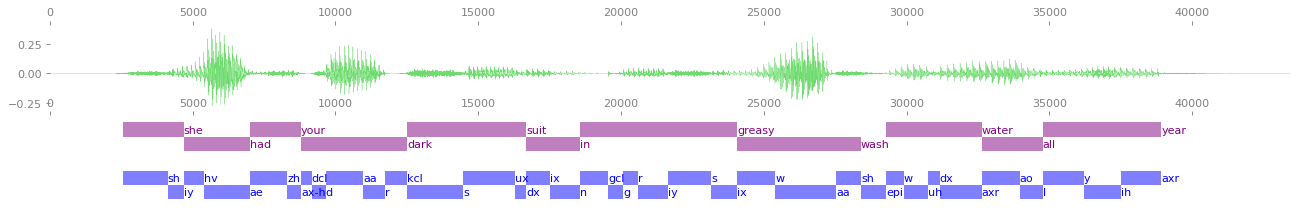

In [2]:
%matplotlib inline
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du
import random

DATA_PATH = 'data/timit/raw/TIMIT'
corpus = tu.Corpus(DATA_PATH)
sentence = corpus.train.sentences_by_phone_df('aa').sentence[0]
du.DrawVerticalPanels([du.AudioPanel(sentence.raw_audio, show_x_axis=True),
                       du.WordsPanel(sentence.words_df, sentence.raw_audio.shape[0], show_x_axis=True),
                       du.PhonesPanel(sentence.phones_df, sentence.raw_audio.shape[0])
                      ])
IPython.display.Audio(sentence.raw_audio,rate=16000)

Обучение классификатора пола по голосу. 

Для этого зададим класс timit_dataloader, который позволяет извлекать метки пола, возраста, идентификатор диктора, а также задает методы предобработки аудиосигнала.

In [3]:
class timit_dataloader:
    def __init__(self, data_path='./data/TIMIT', train_mode=True, age_mode=False):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        # print(self.id_age_dict)
        if train_mode:
            self.trainset = self.create_dataset('train', age_mode=age_mode)
            self.validset = self.create_dataset('valid', age_mode=age_mode)
        self.testset = self.create_dataset('test', age_mode=age_mode)

    def return_sex(self, id):
        return self.id_sex_dict[id]

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode, age_mode=False):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        if age_mode:
            for person in tqdm(people):
                try:
                    target = self.return_age(person.name)
                    for i in range(len(person.sentences)):
                        spectrograms_and_targets.append(
                            self.preprocess_sample(person.sentence_by_index(i).raw_audio, target, age_mode=True))
                except:
                    print(person.name, target)
        else:
            for person in tqdm(people):
                target = self.return_sex(person.name)
                for i in range(len(person.sentences)):
                    spectrograms_and_targets.append(
                        self.preprocess_sample(person.sentence_by_index(i).raw_audio, target))

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 25:
            return 0
        if 25 < age < 40:
            return 0.5
        if age > 40:
            return 1

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        if age_mode:
            # target = self.clasterize_by_age(target)
            target = target/80
        else:
            target = 0 if target == 'F' else 1
        # print(np.array(self.spec_to_image(np.float32(spectrogram))).shape)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return t.tensor(spectrogram, dtype=t.float).to(device, non_blocking=True)

Класс dataloader - формирует батчи данных.

In [4]:
class dataloader:
    def __init__(self, spectrograms, targets):
        self.data = list(zip(spectrograms, targets))

    def next_batch(self, batch_size, device):
        indices = np.random.randint(len(self.data), size=batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [line[1] for line in input]

        return self.torch_batch(source, target, device)

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [
                t.tensor(val, dtype=t.float).to(device, non_blocking=True)
                for val in [source, target]
            ]
        )

In [5]:
#                     architecture
# ===========================================================================

class Model(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(128 * len(window_sizes), 1)

    def forward(self, x):
        # Apply a convolution + max pool layer for each window size
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        probs = torch.sigmoid(logits).view(-1)
        return probs

    def loss(self, probs, targets):
        return nn.BCELoss()(probs.float(), targets.float())

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {device} mode')
patience = 500
best_loss = 1000
cnt = 0
random.seed(1)
torch.manual_seed(0)
np.random.seed(0)

model = Model()
if device == torch.device('cuda'):
    model.cuda()
else:
    model.cpu()
model.train()

using cpu mode


Model(
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 128), stride=(1, 1), padding=(2, 0))
    (1): Conv2d(1, 128, kernel_size=(4, 128), stride=(1, 1), padding=(3, 0))
    (2): Conv2d(1, 128, kernel_size=(5, 128), stride=(1, 1), padding=(4, 0))
  )
  (fc): Linear(in_features=384, out_features=1, bias=True)
)

In [7]:
#          mel-spectrograms of all audio records in dataset
# ===========================================================================

_timit_dataloader = timit_dataloader("data/timit/raw/TIMIT")
train, valid, test = _timit_dataloader.return_data()

trainset = dataloader(*train)
validset = dataloader(*valid)
testset = dataloader(*test)


100%|██████████| 150/150 [00:32<00:00,  4.66it/s]


In [8]:
#                     ML
# ===========================================================================

import torch as t

BATCH_SIZE = 64

optimizer = Adam(
    [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5
)

for i in tqdm(range(60)):

    optimizer.zero_grad()

    input, target = trainset.next_batch(BATCH_SIZE, device=device)
    out = model(input)
    loss = model.loss(out, target)
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        model.eval()

        with torch.no_grad():
            optimizer.zero_grad()

            input, target = validset.next_batch(BATCH_SIZE, device=device)
            out = model(input)
            valid_loss = model.loss(out, target)
            out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
            # print(out, target)
            out = [1. if tmp > 0.5 else 0 for tmp in out]
            print(f'accuracy_score:{accuracy_score(out, target)}')
            print("i {}, valid {}".format(i, valid_loss.item()))
            print("_________")

        model.train()

    if i % 50 == 0 and best_loss > valid_loss.item():
        best_loss = valid_loss.item()
        cnt = 0
    else:
        cnt += 1

    if cnt > patience:
        break
print('training finished')


  2%|▏         | 1/60 [00:01<01:08,  1.16s/it]

accuracy_score:0.640625
i 0, valid 2.1537177562713623
_________


 85%|████████▌ | 51/60 [00:23<00:04,  1.89it/s]

accuracy_score:0.984375
i 50, valid 0.024601640179753304
_________


100%|██████████| 60/60 [00:27<00:00,  2.16it/s]

training finished


In [9]:
model.eval()

def predict(wavfile):
    waveform, _ = librosa.load(wavfile, sr=16000)

    input = _timit_dataloader.preprocess_sample_inference(waveform)
    with torch.no_grad():
        out = model(torch.clone(input).detach().to(device))
        out = out.cpu().detach().numpy()
    print(out)
    out = 'female' if out < 0.5 else 'male'
    return out

In [10]:
input,target = tuple(
            [
                t.tensor(val, dtype=t.float).to(device, non_blocking=True)
                for val in [test[0], test[1]]
            ])

with torch.no_grad():
        out = model(input)
        out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
        out = [1. if tmp > 0.5 else 0 for tmp in out]
        print('accuracy_score:{:.3f}'.format(accuracy_score(out, target)))

accuracy_score:0.958


In [12]:
import numpy as np
import sklearn.metrics
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

"""
Python compute equal error rate (eer)
ONLY tested on binary classification

:param label: ground-truth label, should be a 1-d list or np.array, each element represents the ground-truth label of one sample
:param pred: model prediction, should be a 1-d list or np.array, each element represents the model prediction of one sample
:param positive_label: the class that is viewed as positive class when computing EER
:return: equal error rate (EER)
"""
def compute_eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
    return eer

Равная ошибка 1-го и 2-го рода (EER) = 0.043


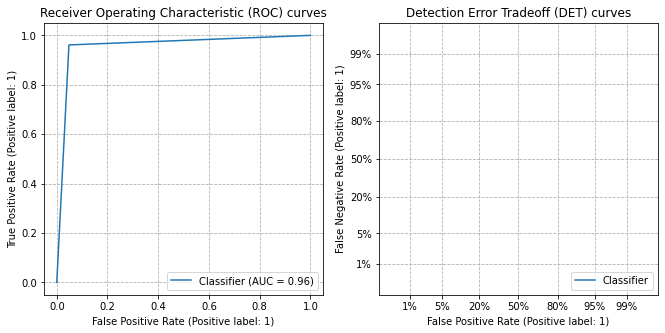

In [13]:
def plot_roc_eer(target, out):
  eer = compute_eer(target, out)
  print('Равная ошибка 1-го и 2-го рода (EER) = {:.3f}'.format(eer))

  # prepare plots
  fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

  RocCurveDisplay.from_predictions(target,out,ax=ax_roc)
  DetCurveDisplay.from_predictions(target,out,ax=ax_det)

  ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
  ax_det.set_title("Detection Error Tradeoff (DET) curves")
  ax_det.grid(linestyle="--")
  ax_roc.grid(linestyle="--")
  
  plt.show()

plot_roc_eer(target, out)

Как видно из графиков, ROC-кривая не гладкая, а на DET-кривой вообще нет точек. Эта проблема связана с тем, что сеть выдает все значения либо около 0, либо около 1, не давая возможности нам плавно изменять порог принятия решения классификации и тем самым менять вероятности ошибок 1-го и 2-го рода.

Напоминим, что ROC-кривая или кривая ошибок – графическая характеристика качества бинарного классификатора, зависимость доли верных положительных классификаций от доли ложных положительных классификаций при варьировании порога решающего правила.

DET-кривая или кривая компромиссного определения ошибки показывает зависимость ошибки 1-го и 2-го рода бинарного классификатора от порога решающего правила.

### Запись своего голоса и проверка работы на реальных данных

In [14]:
#                    Record audio via browser
# ===========================================================================


from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import IPython
import uuid
from google.colab import output


class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    from google.colab import output
    callback_id = 'button-' + str(uuid.uuid4())
    output.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}" style="cursor:pointer;background-color:#EEEEEE;border-color:#E0E0E0;padding:5px 15px;font-size:14px">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb+') as f:
    f.write(b)
  return 'audio.wav'


In [19]:
def classify():
  print("Идет запись в течение 3-х секунд, произнесите что-нибудь ...")  
  record()
  os.system('ffmpeg -i audio.wav -ar 16000 -y audio.wav')
  print(f"Запись аудио закончена, вероятно, что у вас пол: {predict('audio.wav')}")

InvokeButton('Начать запись', classify)

In [20]:
#                    your audio record
# ===========================================================================

IPython.display.Audio('audio.wav')